In [139]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon, LineString
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [140]:
# Load data
houses = gpd.read_file("E:/Master/term2/metaheuristic_optimization/p1/P1/P1/Houses.shp")
educations = gpd.read_file("E:/Master/term2/metaheuristic_optimization/p1/P1/P1/Educational.shp")

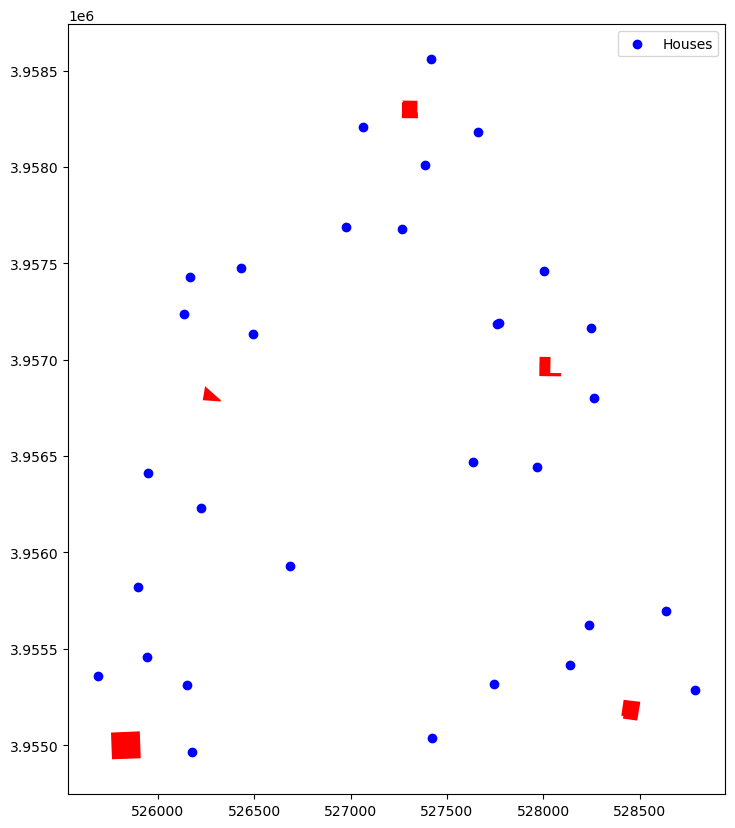

In [141]:
# Plot the layers
fig, ax = plt.subplots(figsize=(10, 10))
houses.plot(ax=ax, color='blue', label='Houses')
educations.plot(ax=ax, color='red', label='Educations')
plt.legend()
plt.show()

In [142]:
# Initialize random assignments
houses["edu"] = np.random.randint(0, 5, len(houses))
edu_center = educations.centroid

In [143]:
# Calculate distances
distances = np.zeros((len(houses), len(educations)))
for i, house in enumerate(houses.geometry):
    for j, edu in enumerate(educations.geometry):
        distances[i, j] = house.distance(edu)

# Assign weights
max_distance = np.max(distances)
weights = 1 - (distances / max_distance)

# Calculate weighted distances
weighted_distances = distances * weights

# Assign education centers
assignments = np.argmin(weighted_distances, axis=1)

# Update the 'edu' column in the houses dataframe
houses["edu"] = assignments

In [144]:
def plot_data(ind):
    if ind is not None:
        lines = gpd.GeoDataFrame({'geometry': []}, geometry='geometry')
        for i in range(len(ind)):
            pt = ind.geometry.iloc[i]
            edu = edu_center[ind.iloc[i]["edu"]]
            line = LineString([pt, edu])
            lines = pd.concat([lines, gpd.GeoSeries([line]).to_frame('geometry')], axis=0)
        lines.crs = houses.crs
        f, ax = plt.subplots(figsize=(10,10))
        educations.plot(ax=ax, color="blue")
        houses.plot(ax=ax, color="red")
        lines.plot(ax=ax, color="black")
    else:
        print("ind is None")

In [145]:
# Function to calculate total distance
def calculate_distance(houses, educations):
    # Ensure both dataframes have a geometry column
    houses = houses.set_geometry('geometry')
    educations = educations.set_geometry('geometry')

    # Calculate distances between each house and its corresponding education location
    distances = houses.geometry.distance(educations.geometry[houses['edu']])

    # Calculate the total distance
    total_dist = distances.sum()

    return total_dist

In [146]:
# Function to calculate population difference
def calculate_population_diff(houses, educations):
    house_pops = houses['Population']
    edu_pops = educations.loc[houses['edu'], 'CAPACITY']
    pop_diff = np.abs(edu_pops - house_pops).sum()
    return pop_diff

In [147]:
# Function to calculate fitness
def calculate_fitness(houses):
    return calculate_distance(houses, educations) + calculate_population_diff(houses, educations)

In [148]:
# Function to initialize population
def initialize_population(population_size):
    population = []
    for _ in range(population_size):
        individual = houses.copy()
        individual["edu"] = np.random.randint(0, 5, len(houses))
        population.append(individual)
    return population

In [149]:
initialize_population(5)

[    Population                        geometry  edu
 0           42  POINT (527760.342 3957186.816)    2
 1           53  POINT (527768.522 3957188.076)    4
 2           50  POINT (526978.290 3957690.856)    2
 3           66  POINT (527267.953 3957679.878)    2
 4           59  POINT (528002.434 3957462.593)    0
 5           57  POINT (528248.143 3957166.014)    1
 6           58  POINT (528262.211 3956800.016)    0
 7           45  POINT (527414.567 3958558.748)    1
 8           47  POINT (527066.185 3958207.499)    3
 9           60  POINT (527388.375 3958008.825)    2
 10          67  POINT (527658.882 3958180.618)    4
 11          53  POINT (526177.087 3954962.737)    1
 12          65  POINT (526150.583 3955314.555)    3
 13          47  POINT (525690.813 3955357.705)    3
 14          50  POINT (526137.892 3957238.632)    2
 15          41  POINT (526492.177 3957132.270)    0
 16          42  POINT (526431.015 3957474.337)    4
 17          56  POINT (526165.152 3957428.688

In [150]:
# Function to select parents
def select_parents(population):
    parents = []
    for _ in range(len(population) // 2):
        parent1, parent2 = random.sample(population, 2)
        if calculate_fitness(parent1) < calculate_fitness(parent2):
            parents.append(parent1)
        else:
            parents.append(parent2)
    return parents

In [151]:
# Function to crossover parents
def crossover_parents(parents):
    offspring = []
    for _ in range(len(parents) // 2):
        parent1, parent2 = random.sample(parents, 2)
        crossover_point = random.randint(1, len(houses) - 1)
        offspring1 = pd.concat([parent1[:crossover_point],  parent2[crossover_point:]], axis=0)
        offspring2 = pd.concat([parent2[:crossover_point],  parent1[crossover_point:]], axis=0)
        offspring.append(offspring1)
        offspring.append(offspring2)
    return offspring

In [152]:
# Function to mutate offspring
def mutate_offspring(offspring, mutation_probability):
    for individual in offspring:
        if random.random() < mutation_probability:
            mutation_point = random.randint(0, len(houses) - 1)
            individual.iloc[mutation_point, -1] = random.randint(0, len(educations) - 1)
    return offspring

In [153]:
def run_algorithm(population_size, crossover_probability, mutation_probability, num_generations):
    best_so_far = houses.copy()
    best_gen_fit = calculate_fitness(houses)
    bsf_fitness = []
    
    population = initialize_population(population_size)
    for i in range(num_generations):
        print("Iteration {} is running...".format(i))
        parents = select_parents(population)
        offspring = crossover_parents(parents)
        offspring = mutate_offspring(offspring, mutation_probability)
        population = offspring
        
        fitnesses = [calculate_fitness(population[i]) for i in range(len(population))]
        if fitnesses:  # Check if fitnesses is not empty
            current_best = min(fitnesses)
            current_best_index = np.argmin(fitnesses)
            if current_best < best_gen_fit :
                best_gen_fit = current_best
                bsf_fitness.append(current_best)
                best_so_far = population[current_best_index]
        
        print(current_best, current_best_index, best_gen_fit)
    
    print("Final Best Fitness: ", best_gen_fit)
    print("Final Best Solution: ", best_so_far)
    
    
    return best_so_far, best_gen_fit

In [154]:
# Run the algorithm
best_solution, best_fitness = run_algorithm(100, 0.5, 0.1, 100)
print("Best Solution: ", best_solution)
print("Best Fitness: ", best_fitness)

Iteration 0 is running...
46215.72118860521 7 46215.72118860521
Iteration 1 is running...
46946.04956199837 23 46215.72118860521
Iteration 2 is running...
43688.991049746255 8 43688.991049746255
Iteration 3 is running...
42303.59735357552 0 42303.59735357552
Iteration 4 is running...
50534.92235096414 0 42303.59735357552
Iteration 5 is running...
50534.92235096414 0 42303.59735357552
Iteration 6 is running...
50534.92235096414 0 42303.59735357552
Iteration 7 is running...
50534.92235096414 0 42303.59735357552
Iteration 8 is running...
50534.92235096414 0 42303.59735357552
Iteration 9 is running...
50534.92235096414 0 42303.59735357552
Iteration 10 is running...
50534.92235096414 0 42303.59735357552
Iteration 11 is running...
50534.92235096414 0 42303.59735357552
Iteration 12 is running...
50534.92235096414 0 42303.59735357552
Iteration 13 is running...
50534.92235096414 0 42303.59735357552
Iteration 14 is running...
50534.92235096414 0 42303.59735357552
Iteration 15 is running...
50534

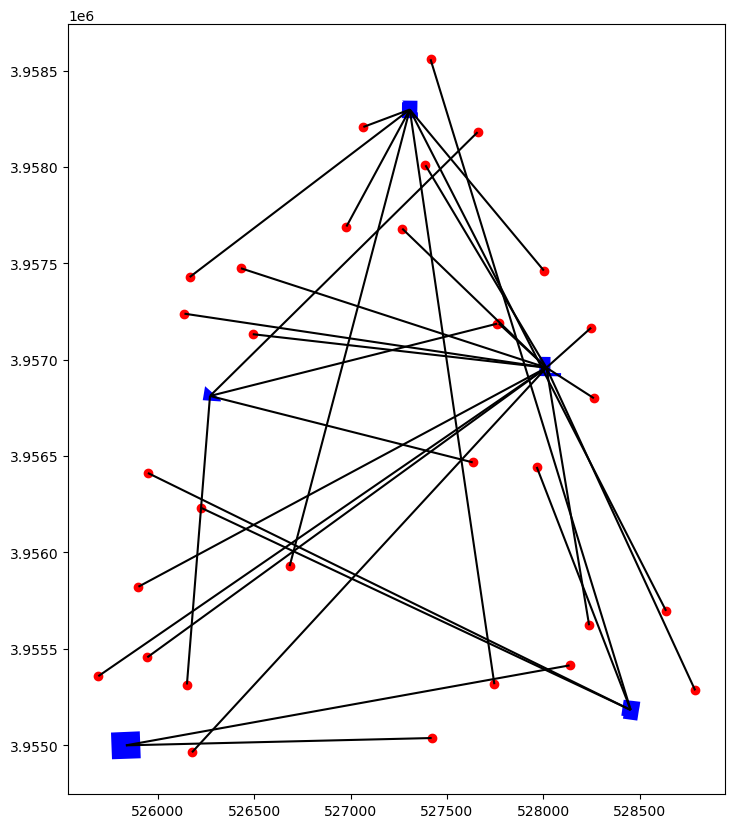

In [155]:
plot_data(best_solution)